Hello there everyone!

I am new to this competition but it looks like this dataset leads to overfitting problems. In addition, it seems like Mercedes is interested in reducing the dataset to a few meaningful variables. Therefore, I thought it was a good idea to try one of the best linear models I know for tackling overfitting that works also as a feature selection method: **Elastic Nets**.

Elastic Nets are essentially a **Lasso/Ridge** hybrid, that entails the minimization of an objective function that includes both **L1** (Lasso) and **L2** (Ridge) norms. You can find more about ElasticNets [here][1].  

For the sake of this notebook it is important to notice that Elastic nets depends on two parameters: 

* the **l1_ratio**, i.e. the tradeoff between the two norms (l1_ratio = 0 --> Ridge,  l1_ratio = 1 --> Lasso, 0<l1_ration<1 --> Mix of the two);
* **alpha**, that regulates the amount of penalty applied.

It is important to know that minimizing the L1 norm will force some coefficients to shrink to zero, and that's why Elastic Nets can be used as feature selection techniques. Besides, when there's a high degree of collinearity in the data, the cross-validation procedure used to determine these two parameters will return low l1_ratio since Ridge tends to outperform Lasso in these cases.

Ok... let's use scikit-learn and see how these methods perfom and which features they select!

  [1]: http://www.onthelambda.com/2015/08/19/kickin-it-with-elastic-net-regression/

# Initialization

In [1]:
# load modules
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data
train_df  = pd.read_csv('../input/train.csv')
test_df  = pd.read_csv('../input/test.csv')

In [3]:
# get train_y, test ids and unite datasets to perform
train_y = train_df['y']
train_df.drop('y', axis = 1, inplace = True)
test_ids = test_df.ID.values
all_df = pd.concat([train_df,test_df], axis = 0)

# ...one hot encoding of categorical variables
categorical =  ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]
for f in categorical:
    dummies = pd.get_dummies(all_df[f], prefix = f, prefix_sep = '_')
    all_df = pd.concat([all_df, dummies], axis = 1)

# drop original categorical features
all_df.drop(categorical, axis = 1, inplace = True)

In [4]:
# get feature dataset for test and training        
train_X = all_df.drop(["ID"], axis=1).iloc[:len(train_df),:]
test_X = all_df.drop(["ID"], axis=1).iloc[len(train_df):,:]

In [5]:
print(train_X.head())
print(test_X.head())

   X10  X11  X12  X13  X14  X15  X16  X17  X18  X19  ...   X8_p  X8_q  X8_r  \
0    0    0    0    1    0    0    0    0    1    0  ...      0     0     0   
1    0    0    0    0    0    0    0    0    1    0  ...      0     0     0   
2    0    0    0    0    0    0    0    1    0    0  ...      0     0     0   
3    0    0    0    0    0    0    0    0    0    0  ...      0     0     0   
4    0    0    0    0    0    0    0    0    0    0  ...      0     0     0   

   X8_s  X8_t  X8_u  X8_v  X8_w  X8_x  X8_y  
0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0  
2     0     0     0     0     0     1     0  
3     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0  

[5 rows x 579 columns]
   X10  X11  X12  X13  X14  X15  X16  X17  X18  X19  ...   X8_p  X8_q  X8_r  \
0    0    0    0    0    0    0    0    0    0    0  ...      0     0     0   
1    0    0    0    0    0    0    0    0    0    1  ...      0    

# Model development and testing

In [6]:
# Let's perform a cross-validation to find the best combination of alpha and l1_ratio
from sklearn.linear_model import ElasticNetCV, ElasticNet

cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

In [7]:
cv_model.fit(train_X, train_y)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=2000,
       n_alphas=100, n_jobs=-1, normalize=True, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [8]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00314540
Optimal l1_ratio: 1.000
Number of iterations 603


**l1_ratio = 1**, that means we are just using Lasso.

In [9]:
# train model with best parameters from CV
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(train_X, train_y)

ElasticNet(alpha=0.0031453993038814206, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=603, normalize=True, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [10]:
# r2 score on training dataset
print(r2_score(train_y, model.predict(train_X)))

0.586978770942


Uncomment below if you want the predictions on the test dataset (LB 0.547+)

In [11]:
# preds = model.predict(test_X)
# df_sub = pd.DataFrame({'ID': test_ids, 'y': preds})
# df_sub.to_csv('elnet_submission_dummies.csv', index=False)

# Feature importance
Let's see the importance of each feature based on the absolute value of their coefficients 

68 features, reduction of 88.26%


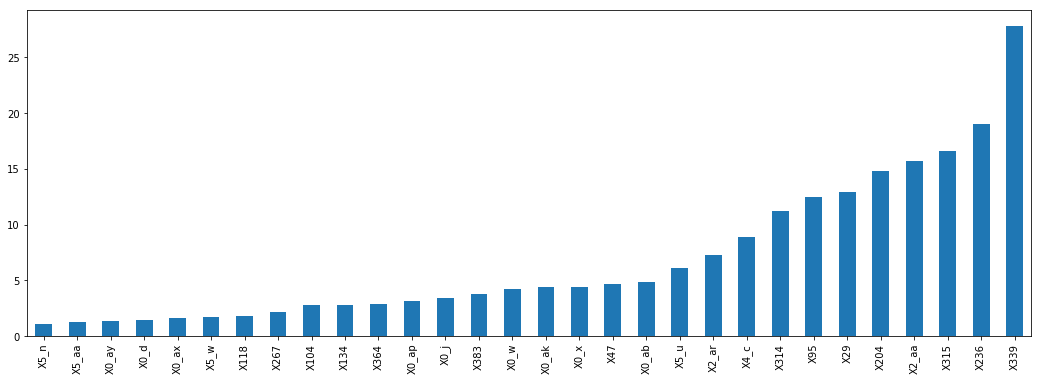

In [12]:
feature_importance = pd.Series(index = train_X.columns, data = np.abs(model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))

## It's nice to see how these features compares with those selected by xgboost or other nonlinear methods. Anyway, 88.26% features reduction (with respect to dataset with dummies) looks nice. Besides, the performance on the LB of this linear method seems to be close to those of more sophisticated ones. 

Vote this notebook if you liked it :P

Cheers